### Imports & Load Labeled Data

In [154]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# 1. Load Labeled Data
df = pd.read_parquet("../data/EURUSD_H1_Labeled.parquet")

print(f"✅ Loaded {len(df)} rows.")
display(df.tail(3))

✅ Loaded 37185 rows.


,open,high,low,close,tick_volume,spread,real_volume,tr,atr,label
time,,,,,,,,,,
2025-12-23 01:00:00,1.17583,1.17655,1.17583,1.17635,799,9,0,0.00072,0.000997,1
2025-12-23 02:00:00,1.17635,1.17703,1.17628,1.17689,850,8,0,0.00075,0.000979,0
2025-12-23 03:00:00,1.17689,1.17760,1.17658,1.17729,1198,8,0,0.00102,0.000982,0


### "Aggressive SOTA" Feature Set

### Veto and correlation

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. VETO FUNCTION (Removes Bad Trades) ---
def apply_spread_veto(df, max_spread_points=20, spread_col='spread', label_col='label'):
    """
    Forces labels to 0 if spread is too high. 
    """
    df_veto = df.copy()
    
    # Safety checks
    if spread_col not in df_veto.columns:
        print(f"⚠️ Column '{spread_col}' not found. Skipping veto.")
        return df_veto

    # Stats before
    orig_buys = len(df_veto[df_veto[label_col] == 1])
    orig_sells = len(df_veto[df_veto[label_col] == -1])

    # Apply Veto
    mask = df_veto[spread_col] > max_spread_points
    df_veto.loc[mask, label_col] = 0
    
    # Stats after
    new_buys = len(df_veto[df_veto[label_col] == 1])
    new_sells = len(df_veto[df_veto[label_col] == -1])
    
    print(f"--- 🛡️ SPREAD VETO REPORT ---")
    print(f"🚫 Vetoed Candles: {mask.sum()}")
    print(f"📉 Trades Removed: {orig_buys - new_buys} Buys, {orig_sells - new_sells} Sells")
    
    return df_veto

# --- 2. SOTA FEATURE ENGINEERING (Fixed Debugging) ---
def apply_aggressive_features(df):
    import numpy as np
    temp = df.copy()
    
    print("🚀 Applying Optimized SOTA Features (UTC Sessions)...")

    # A. Log Returns
    temp['log_ret'] = np.log(temp['close'] / temp['close'].shift(1))
    
    # B. Volatility (Garman-Klass)
    log_hl = np.log(temp['high'] / temp['low'])
    log_co = np.log(temp['close'] / temp['open'])
    temp['vol_qk'] = 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2

    # C. RSI Z-Score (Momentum)
    delta = temp['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/14, min_periods=14).mean()
    avg_loss = loss.ewm(alpha=1/14, min_periods=14).mean()
    rs = avg_gain / avg_loss
    temp['rsi_val'] = 100 - (100 / (1 + rs))
    temp['rsi_z'] = (temp['rsi_val'] - temp['rsi_val'].rolling(50).mean()) / temp['rsi_val'].rolling(50).std()

    # D. Multi-SMA Distances (Trend & Mean Reversion)
    # Keeping 20 and 50 as they provide distinct medium/short term views
    temp['dist_sma20'] = (temp['close'] - temp['close'].rolling(20).mean()) / temp['close'].rolling(20).mean()
    temp['dist_sma50'] = (temp['close'] - temp['close'].rolling(50).mean()) / temp['close'].rolling(50).mean()
    
    # E. Bollinger Band Width (Compression)
    sma_20 = temp['close'].rolling(20).mean()
    std_20 = temp['close'].rolling(20).std()
    temp['bb_width'] = (4 * std_20) / sma_20

    # F. Advanced UTC Time Encoding
    temp['hour_sin'] = np.sin(2 * np.pi * temp.index.hour / 24)
    temp['hour_cos'] = np.cos(2 * np.pi * temp.index.hour / 24)
    
    # Session Flags (UTC)
    temp['is_london'] = ((temp.index.hour >= 8) & (temp.index.hour <= 16)).astype(int)
    temp['is_ny'] = ((temp.index.hour >= 13) & (temp.index.hour <= 21)).astype(int)
    temp['is_asia'] = ((temp.index.hour >= 0) & (temp.index.hour <= 7)).astype(int) # Added Asia
    temp['is_overlap'] = (temp['is_london'] & temp['is_ny']).astype(int)
    # "The Gap": 22:00 - 00:00 (Very low liquidity)
    temp['is_dead_zone'] = ((temp.index.hour >= 22) | (temp.index.hour == 23)).astype(int)

    # G. Target
    temp['target_next_return'] = temp['log_ret'].shift(-1)
    
    # --- FINAL WHITELIST (Optimized for Predictive Power) ---
    cols_to_keep = [
        'log_ret', 'vol_qk', 'rsi_z', 'dist_sma20', 'dist_sma50', 
        'bb_width', 'hour_sin', 'hour_cos', 
        'is_london', 'is_ny', 'is_asia', 'is_overlap', 'is_dead_zone',
        'target_next_return',
    ]
    
    if 'label' in temp.columns:
        cols_to_keep.append('label')
        
    df_final = temp[cols_to_keep].dropna().copy()
    
    print(f"✅ Final Feature Set Ready. Rows: {len(df)} -> {len(df_final)}")
    return df_final

    
def check_correlation(df, target_col='target_next_return'):
    print(f"\n--- 🔍 CORRELATION CHECK (Target: {target_col}) ---")
    
    if df.empty:
        print("❌ Error: DataFrame is empty! Cannot check correlation.")
        return

    # Filter numeric only
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate Correlation
    corr = numeric_df.corr()
    
    # Check if Target correlation exists (it might be NaN if variance is 0)
    if target_col not in corr or pd.isna(corr[target_col].max()):
        print(f"⚠️ Warning: Correlation failed. '{target_col}' might be constant (all zeros).")
        print(f"   Target Variance: {df[target_col].var()}")
        return

    # Check for Leakage
    target_corr = corr[target_col].drop(target_col)
    leakage = target_corr[abs(target_corr) > 0.95]
    
    if not leakage.empty:
        print("⚠️ POSSIBLE LEAKAGE DETECTED! (Corr > 0.95):")
        print(leakage)
    else:
        print("✅ No obvious leakage.")
        
    # Plot
    top_cols = target_corr.abs().sort_values(ascending=False).head(15).index.tolist()
    if target_col not in top_cols: top_cols.append(target_col)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[top_cols].corr(), annot=True, cmap='RdBu', center=0, fmt=".2f")
    plt.title(f"Correlation Heatmap vs {target_col}")
    plt.show()

### # Execution

--- 🛡️ SPREAD VETO REPORT ---
🚫 Vetoed Candles: 1283
📉 Trades Removed: 230 Buys, 162 Sells
🚀 Applying Optimized SOTA Features (UTC Sessions)...
✅ Final Feature Set Ready. Rows: 37185 -> 37121

--- 🔍 CORRELATION CHECK (Target: target_next_return) ---
✅ No obvious leakage.


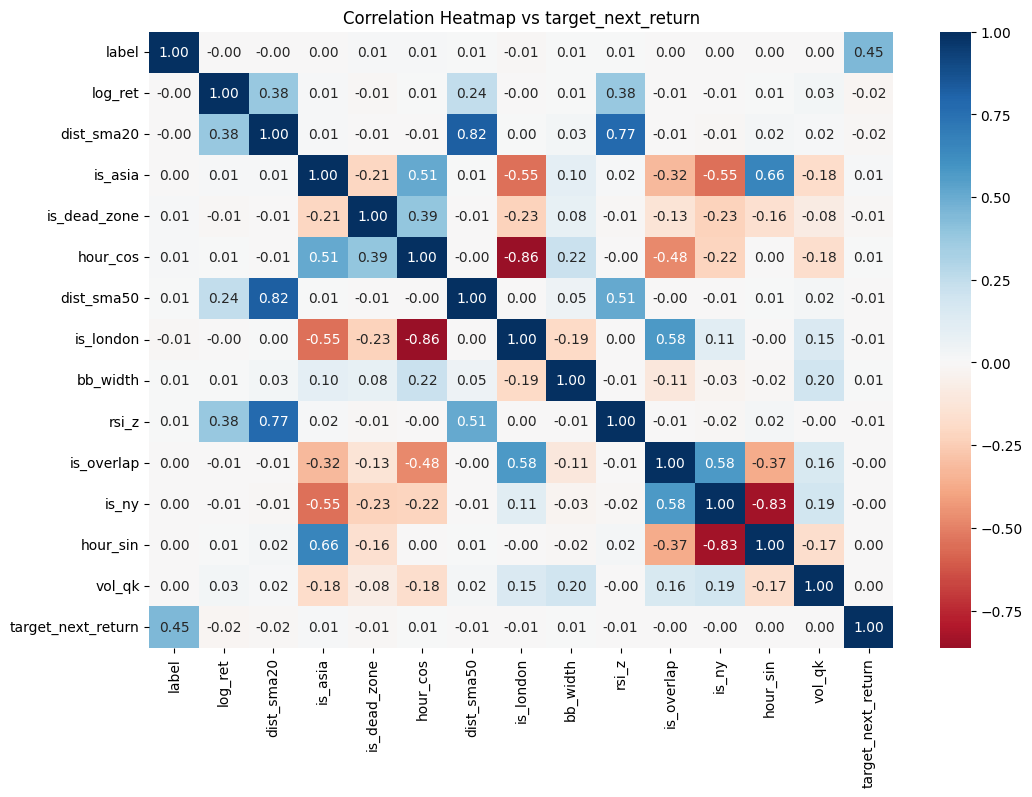

In [156]:
# 1. Apply Filters
df_vetoed = apply_spread_veto(df, max_spread_points=20)

# 2. Engineer Features
df_final = apply_aggressive_features(df_vetoed)

# 3. Check Correlation
check_correlation(df_final, target_col='target_next_return')

🚀 Starting Feature Importance Check for Target: 'label'...
   ℹ️ Analyzing 13 Features: ['log_ret', 'vol_qk', 'rsi_z', 'dist_sma20', 'dist_sma50', 'bb_width', 'hour_sin', 'hour_cos', 'is_london', 'is_ny', 'is_asia', 'is_overlap', 'is_dead_zone']
   🧠 Calculating Mutual Information (Non-linear)...
   🌲 Training Quick Random Forest for Importance...

--- 🏆 FEATURE PREDICTIVE POWER RANKING ---


,Mutual_Info,RF_Importance,Total_Power
hour_cos,1.00,1.00,1.000
is_london,0.84,0.52,0.680
hour_sin,0.27,0.56,0.415
is_overlap,0.19,0.11,0.150
is_dead_zone,0.18,0.05,0.115
is_ny,0.04,0.12,0.080
bb_width,0.11,0.05,0.080
is_asia,0.05,0.09,0.070
vol_qk,0.07,0.05,0.060
dist_sma20,0.06,0.01,0.035


C:\Users\casus\AppData\Local\Temp\ipykernel_25420\255645652.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Mutual_Info'], y=results.index, palette="viridis")
C:\Users\casus\AppData\Local\Temp\ipykernel_25420\255645652.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['RF_Importance'], y=results.index, palette="magma")


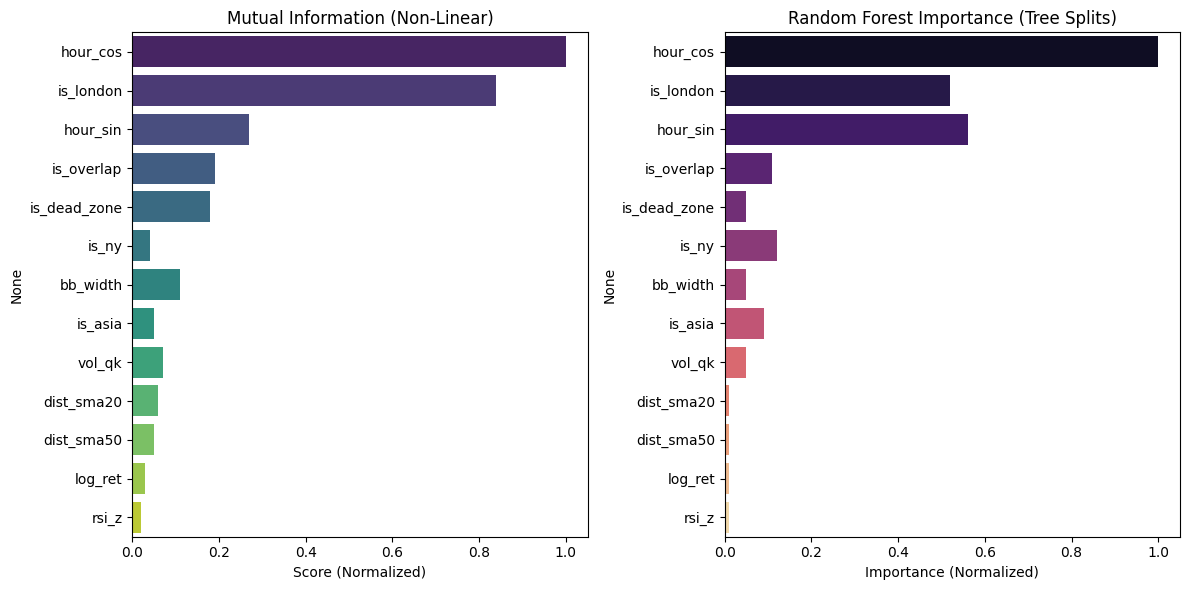

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def check_feature_importance(df, target_col='label', is_classification=True):
    """
    Analyzes predictive power using Mutual Information and Random Forest Importance.
    """
    print(f"🚀 Starting Feature Importance Check for Target: '{target_col}'...")
    
    # 1. Clean & Separate X (Features) and y (Target)
    df_clean = df.copy().dropna()
    
    # Drop known non-features or future leaks
    drop_cols = ['label', 'target_next_return', 'close', 'high', 'low', 'open', 'time']
    # Only drop columns that actually exist in the dataframe
    drop_cols = [c for c in drop_cols if c in df_clean.columns]
    
    X = df_clean.drop(columns=drop_cols)
    y = df_clean[target_col]
    
    # Ensure all data is numeric for sklearn
    X = X.select_dtypes(include=[np.number])
    
    print(f"   ℹ️ Analyzing {X.shape[1]} Features: {list(X.columns)}")
    
    # 2. Calculate Mutual Information
    print("   🧠 Calculating Mutual Information (Non-linear)...")
    if is_classification:
        mi_scores = mutual_info_classif(X, y, random_state=42)
    else:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        
    mi_series = pd.Series(mi_scores, index=X.columns, name="Mutual_Info")
    
    # 3. Calculate Random Forest Importance
    print("   🌲 Training Quick Random Forest for Importance...")
    if is_classification:
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    else:
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
        
    model.fit(X, y)
    rf_series = pd.Series(model.feature_importances_, index=X.columns, name="RF_Importance")
    
    # 4. Combine & Display
    results = pd.concat([mi_series, rf_series], axis=1)
    
    # Normalize Random Forest to 0-1 scale relative to max for easier comparison
    results['RF_Importance'] = (results['RF_Importance'] / results['RF_Importance'].max()).round(2)
    results['Mutual_Info'] = (results['Mutual_Info'] / results['Mutual_Info'].max()).round(2)
    
    # Sort by average power
    results['Total_Power'] = (results['Mutual_Info'] + results['RF_Importance']) / 2
    results = results.sort_values(by='Total_Power', ascending=False)
    
    print("\n--- 🏆 FEATURE PREDICTIVE POWER RANKING ---")
    display(results)
    
    # 5. Plot
    plt.figure(figsize=(12, 6))
    
    # Plot Mutual Info
    plt.subplot(1, 2, 1)
    sns.barplot(x=results['Mutual_Info'], y=results.index, palette="viridis")
    plt.title("Mutual Information (Non-Linear)")
    plt.xlabel("Score (Normalized)")
    
    # Plot RF Importance
    plt.subplot(1, 2, 2)
    sns.barplot(x=results['RF_Importance'], y=results.index, palette="magma")
    plt.title("Random Forest Importance (Tree Splits)")
    plt.xlabel("Importance (Normalized)")
    
    plt.tight_layout()
    plt.show()

# --- RUN THE CHECK ---
# Option A: Check power to predict the LABEL (Buy/Sell/Hold) -> Classification
check_feature_importance(df_final, target_col='label', is_classification=True)

# Option B: Check power to predict raw RETURN (Numerical) -> Regression
# check_feature_importance(df_final, target_col='target_next_return', is_classification=False)

### 5. SAVE THE FINAL DATASET

In [158]:
# Define the filename
output_path = "../data/EURUSD_H1_SOTA_Features.parquet"

# Save to Parquet
df_final.to_parquet(output_path)

print(f"✨ Success! Engineered dataset saved to: {output_path}")
print(f"📊 Final dimensions: {df_final.shape}")
print(f"📅 Index Range: {df_final.index.min()} to {df_final.index.max()}")

✨ Success! Engineered dataset saved to: ../data/EURUSD_H1_SOTA_Features.parquet
📊 Final dimensions: (37121, 15)
📅 Index Range: 2020-01-07 04:00:00 to 2025-12-23 02:00:00
